In [22]:
# install missing package for this notebook environment 
# %pip install yfinance

import sys
from typing import List, Tuple
import os as os
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

In [23]:
def download_adj_close(tickers: dict, 
                       start_date: str = "2020-05-22", 
                       end_date: str = "2025-05-21",
                       output_dir: str = "stock_data") -> pd.DataFrame:
    """
    Descarga datos Ajustados (Adj Close) para cada ticker individualmente,
    los guarda en archivos CSV, y devuelve un DataFrame combinado.

    Parámetros
    ----------
    tickers : dict
        Diccionario {ticker_yfinance: nombre_amigable}
    start_date : str
        Fecha inicial de descarga
    end_date : str
        Fecha final de descarga
    output_dir : str
        Carpeta donde se guardarán los archivos CSV

    Returns
    -------
    pd.DataFrame:
        DataFrame con columnas = nombres amigables y filas = fechas.
    """

    # Crear directorio si no existe
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    combined_df = pd.DataFrame()

    print("1) Iniciando descarga individual de tickers...\n")

    for yfinance_ticker, friendly_name in tickers.items():
        try:
            print(f"Descargando datos para {friendly_name} ({yfinance_ticker})...")

            # Descargar Adj Close (sin ajustar)
            data = yf.download(
                yfinance_ticker,
                start=start_date,
                end=end_date,
                auto_adjust=False,
                progress=False
            )["Adj Close"]

            # Normalizar a DataFrame
            df = pd.DataFrame(data)
            df.columns = [friendly_name]

            # Guardar en CSV
            filename = f"{output_dir}/{friendly_name.replace(' ', '_')}.csv"
            df.to_csv(filename)
            print(f" - Archivo guardado en: {filename}")
            print(f" - Observaciones descargadas: {df.shape[0]}\n")

            # Combinar
            combined_df = pd.concat([combined_df, df], axis=1)

        except Exception as e:
            print(f"Error al descargar {friendly_name}: {str(e)}\n")

    print("2) Proceso completado.\n")
    print("3) Primeras filas del DataFrame combinado:")
    print(combined_df.head())

    return combined_df



def compute_log_returns(adj_close: pd.DataFrame) -> Tuple[pd.DataFrame, pd.Series, pd.DataFrame]:
    """
    Calcula rendimientos logarítmicos diarios, medias anuales y matriz de covarianza anual.
    Incluye auditoría paso a paso.
    """
    print("\n2) Calculando rendimientos logarítmicos diarios...")
    daily_log_ret = np.log(adj_close / adj_close.shift(252)).dropna()

    print(daily_log_ret.head())

    print("\n3) Media diaria y anualización...")
    annual_mean = daily_log_ret.mean() 
    print(annual_mean)

    print("\n4) Matriz de covarianza anual...")
    cov_annual = daily_log_ret.cov()
    print(cov_annual)

    return daily_log_ret, annual_mean, cov_annual


def min_variance_weights(cov_matrix: pd.DataFrame) -> pd.Series:
    """
    Calcula pesos del portafolio de mínima varianza mediante fórmula cerrada:
    
    w = Σ^{-1}1 / (1^T Σ^{-1} 1)
    """
    print("\n5) Calculando pesos del portafolio de mínima varianza...")

    n = len(cov_matrix)
    ones = np.ones(n)

    try:
        sigma_inv = np.linalg.inv(cov_matrix.values)
        print(" - Inversa calculada correctamente.")
    except np.linalg.LinAlgError:
        sigma_inv = np.linalg.pinv(cov_matrix.values)
        print(" - Matriz singular, se usa pseudo-inversa.")

    num = sigma_inv @ ones
    den = ones @ sigma_inv @ ones

    weights = num / den
    weights = pd.Series(weights, index=cov_matrix.index)

    print(" - Suma de pesos:", weights.sum())
    return weights / weights.sum()


def portfolio_metrics(weights: pd.Series, annual_mean: pd.Series, cov_annual: pd.DataFrame,
                      rf: float = 0.0) -> dict:
    """
    Calcula retorno esperado, volatilidad y Sharpe.
    """
    print("\n6) Calculando métricas del portafolio...")

    w = weights.values
    mu = annual_mean.loc[weights.index].values
    sigma = cov_annual.loc[weights.index, weights.index].values

    port_return = float(np.dot(w, mu))
    port_vol = float(np.sqrt(w.T @ sigma @ w))
    sharpe = np.nan if port_vol == 0 else (port_return - rf) / port_vol

    print(f" - Retorno anual esperado: {port_return}")
    print(f" - Volatilidad anual: {port_vol}")
    print(f" - Sharpe ratio: {sharpe}")

    return {
        "return": port_return,
        "volatility": port_vol,
        "sharpe": sharpe
    }

In [24]:
def show_results(weights: pd.Series, annual_mean: pd.Series, cov_annual: pd.DataFrame,
                 show_frontier: bool = True, n_portfolios: int = 1000000):
    """
    Muestra tabla resumen, gráficos de pesos y frontera eficiente simulada.
    """
    print("\n7) Resultados finales:")

    summary = pd.DataFrame({
        "Peso (%)": weights * 100,
        "Retorno Anual": annual_mean[weights.index],
    })

    print(summary)

    plt.figure(figsize=(8, 5))
    plt.bar(weights.index, weights.values * 100)
    plt.title("Pesos del Portafolio de Mínima Varianza")
    plt.ylabel("Peso (%)")
    plt.show()

    if show_frontier:
        print("\n8) Generando frontera eficiente simulada...")

        rng = np.random.default_rng(42)
        tickers = annual_mean.index
        n_assets = len(tickers)

        mu = annual_mean.values
        sigma = cov_annual.values

        # Matrices para almacenar resultados
        results = np.zeros((n_portfolios, 3))  # [vol, ret, sharpe]
        weights_list = []

        for i in range(n_portfolios):
            w = np.random.random(n_assets)
            w /= w.sum()
            weights_list.append(w)
            sharpes = (np.dot(w, mu)) / np.sqrt(
                
                
                w.T @ sigma @ w)
            port_return = np.dot(w, mu)
            port_vol = np.sqrt(w.T @ sigma @ w)
            results[i] = [port_vol, port_return, sharpes]

        vols = results[:, 0]
        rets = results[:, 1]
        sharpes = results[:, 2]

        # Índices de portafolios clave
        idx_max_sharpe = np.nanargmax(sharpes)
        idx_min_vol = np.argmin(vols)

        # Marcadores
        max_sharpe_w = weights_list[idx_max_sharpe]
        min_var_w = weights_list[idx_min_vol]

        # === Gráfico ===
        plt.figure(figsize=(12, 8))

        scatter = plt.scatter(
            vols, rets, c=sharpes,
            cmap='viridis', s=10, alpha=0.5
        )

        # Mínima varianza (azul)
        plt.scatter(
            vols[idx_min_vol], rets[idx_min_vol],
            color='blue', marker='X', s=200,
            label='Mínima Varianza'
        )

        # Máximo Sharpe (rojo)
        plt.scatter(
            vols[idx_max_sharpe], rets[idx_max_sharpe],
            color='red', marker='*', s=250,
            label='Máxima Sharpe'
        )

        # Títulos y etiquetas en español
        plt.title("Frontera Eficiente con Portafolios Simulados", fontsize=16)
        plt.xlabel("Riesgo (Volatilidad)", fontsize=14)
        plt.ylabel("Retorno Esperado", fontsize=14)

        # Barra de color
        cbar = plt.colorbar(scatter)
        cbar.set_label("Sharpe Ratio", fontsize=13)

        plt.grid(alpha=0.3)
        plt.legend(fontsize=12)

        plt.show()
        
        print(" - Portafolio de Máxima Sharpe Pesos (%): \n" )
        max_sharpe_weights = pd.Series(max_sharpe_w, index=tickers)
        print((max_sharpe_weights * 100).round(2))  
        print("\n") 
        print(" - Portafolio de Máximo Sharpe Ratio: \n" )
        print(f"   Retorno: {rets[idx_max_sharpe]}")
        print(f"   Volatilidad: {vols[idx_max_sharpe]}")
        print(f"   Sharpe Ratio: {sharpes[idx_max_sharpe]}\n")   
        

In [25]:
tickers = {
	"BIMBOA.MX": "BIMBOA",
	"GCARSOA1.MX": "GCARSOA1",
	"GMEXICOB.MX": "GMEXICOB",
	"KOFUBL.MX": "KOFUBL",
	"ALSEA.MX": "ALSEA"
}

# Descarga
adj_close = download_adj_close(tickers)

# Cálculos
daily_log, annual_mean, cov_annual = compute_log_returns(adj_close)


1) Iniciando descarga individual de tickers...

Descargando datos para BIMBOA (BIMBOA.MX)...
 - Archivo guardado en: stock_data/BIMBOA.csv
 - Observaciones descargadas: 1257

Descargando datos para GCARSOA1 (GCARSOA1.MX)...
 - Archivo guardado en: stock_data/GCARSOA1.csv
 - Observaciones descargadas: 1257

Descargando datos para GMEXICOB (GMEXICOB.MX)...
 - Archivo guardado en: stock_data/GMEXICOB.csv
 - Observaciones descargadas: 1257

Descargando datos para KOFUBL (KOFUBL.MX)...
 - Archivo guardado en: stock_data/KOFUBL.csv
 - Observaciones descargadas: 1257

Descargando datos para ALSEA (ALSEA.MX)...
 - Archivo guardado en: stock_data/ALSEA.csv
 - Observaciones descargadas: 1257

2) Proceso completado.

3) Primeras filas del DataFrame combinado:
               BIMBOA   GCARSOA1   GMEXICOB     KOFUBL      ALSEA
Date                                                             
2020-05-22  32.737144  44.877827  38.177254  74.587303  17.997326
2020-05-25  32.479221  44.397091  37.633060

In [26]:
# Pesos óptimos
weights = min_variance_weights(cov_annual)

# Métricas del portafolio
metrics = portfolio_metrics(weights, annual_mean, cov_annual, 0.0751) #ajusta el rf 



5) Calculando pesos del portafolio de mínima varianza...
 - Inversa calculada correctamente.
 - Suma de pesos: 1.0000000000000002

6) Calculando métricas del portafolio...
 - Retorno anual esperado: 0.17617209480317333
 - Volatilidad anual: 0.07204043675070927
 - Sharpe ratio: 1.4029911444446959



7) Resultados finales:
           Peso (%)  Retorno Anual
BIMBOA     2.580277       0.120420
GCARSOA1   3.113756       0.237295
GMEXICOB  22.504494       0.141478
KOFUBL    80.622463       0.186324
ALSEA     -8.820991       0.185712


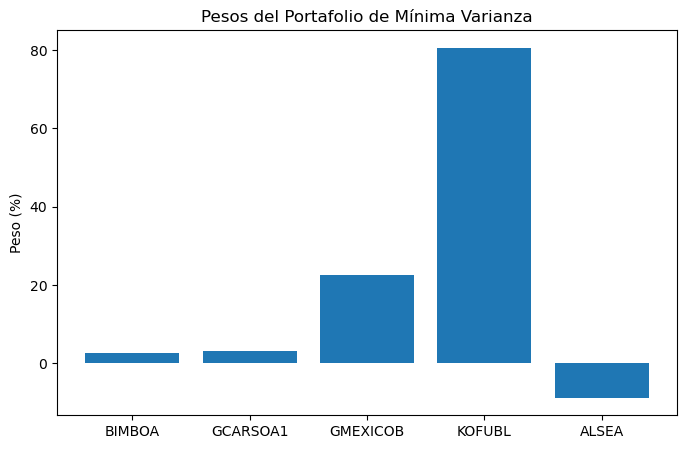


8) Generando frontera eficiente simulada...


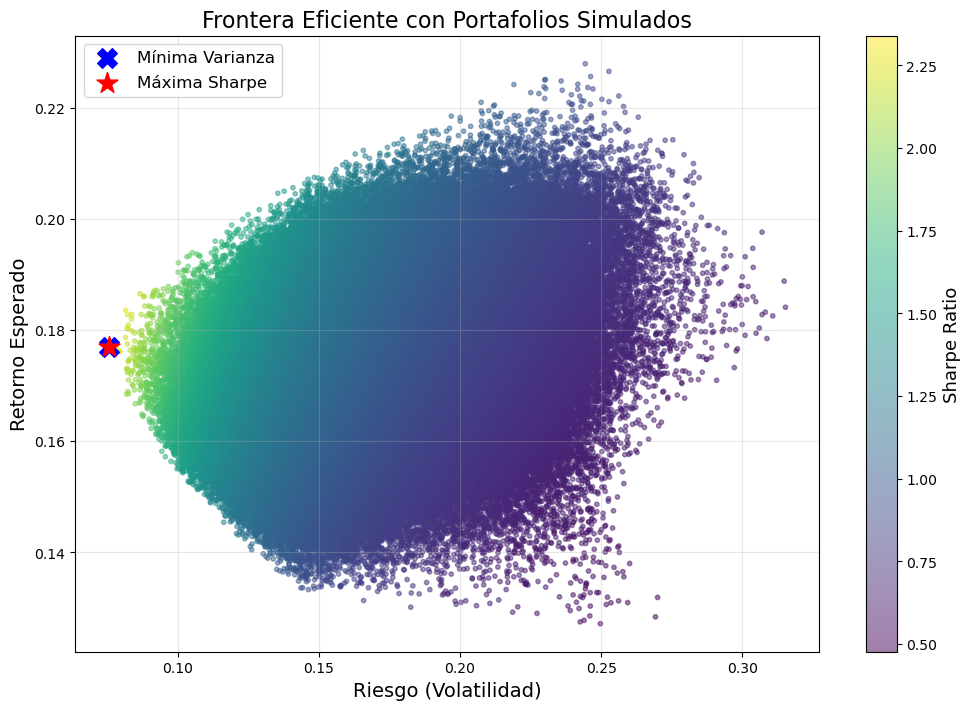

 - Portafolio de Máxima Sharpe Pesos (%): 

BIMBOA       2.33
GCARSOA1     0.34
GMEXICOB    17.88
KOFUBL      79.28
ALSEA        0.17
dtype: float64


 - Portafolio de Máximo Sharpe Ratio: 

   Retorno: 0.17694232404376264
   Volatilidad: 0.07561806667137617
   Sharpe Ratio: 2.3399477377902986



In [27]:
show_results(weights, annual_mean, cov_annual, show_frontier=True, n_portfolios=500000)